# Preprocessing for electric dataset

TODO's
- consider PCA

In [1]:
import joblib
import pandas as pd
from config import DATABASE_FILE_DTYPES, DATABASE_FILE_INDEX, DENSITY_THRESHOLD, ELECTRIC_TARGET, MERGED_ELECTRIC_FILE, OUTPUT_DIR, REPLACE_STRING_OTHER, SCALER_ELECTRIC_FILE, TRAIN_TEST_SPLIT_ELECTRIC_FILE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [31]:
# disable preprocessing analysis if you want to save compute time
DO_PREP_ANALYSIS = True

In [3]:
# load dataset for electric cars
df = pd.read_csv(MERGED_ELECTRIC_FILE, dtype=DATABASE_FILE_DTYPES, index_col=DATABASE_FILE_INDEX)

In [4]:
df.columns

Index(['member_state', 'manufacturer_name_eu', 'vehicle_type',
       'commercial_name', 'category_of_vehicle', 'fuel_type', 'fuel_mode',
       'innovative_technologies', 'mass_vehicle', 'weltp_test_mass',
       'engine_capacity', 'engine_power', 'erwltp', 'year', 'electric_range',
       'electric_energy_consumption', 'fuel_consumption',
       'specific_co2_emissions'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3945297 entries, 56003781 to 134630842
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   member_state                 object 
 1   manufacturer_name_eu         object 
 2   vehicle_type                 object 
 3   commercial_name              object 
 4   category_of_vehicle          object 
 5   fuel_type                    object 
 6   fuel_mode                    object 
 7   innovative_technologies      object 
 8   mass_vehicle                 float64
 9   weltp_test_mass              float64
 10  engine_capacity              float64
 11  engine_power                 float64
 12  erwltp                       float64
 13  year                         int64  
 14  electric_range               float64
 15  electric_energy_consumption  float64
 16  fuel_consumption             float64
 17  specific_co2_emissions       float64
dtypes: float64(9), int64(1), object(8)
mem

In [6]:
def categorize_categorical_quantitive_cols(df):
    cat_cols = pd.DataFrame.select_dtypes(df, include=["object"]).columns
    quant_cols = df.select_dtypes(exclude=["object"]).columns

    return cat_cols, quant_cols

In [7]:
cols_to_be_dropped = list()

cat_cols, quant_cols = categorize_categorical_quantitive_cols(df)

## Remove columns below density threshold

In [8]:
missing_percentage = df.isna().sum() / len(df)
print(missing_percentage)

member_state                   0.000000
manufacturer_name_eu           0.000000
vehicle_type                   0.000221
commercial_name                0.005351
category_of_vehicle            0.005234
fuel_type                      0.000000
fuel_mode                      0.000000
innovative_technologies        0.999567
mass_vehicle                   0.000016
weltp_test_mass                0.043012
engine_capacity                1.000000
engine_power                   0.069891
erwltp                         1.000000
year                           0.000000
electric_range                 0.115409
electric_energy_consumption    0.036422
fuel_consumption               0.999976
specific_co2_emissions         0.000003
dtype: float64


In [9]:
cols_to_be_dropped = list()

for col, percentage in missing_percentage.items():
    if percentage > DENSITY_THRESHOLD:
        cols_to_be_dropped.append(col)

print(f"Columns to be dropped due to availability density below threshold: {cols_to_be_dropped}")

Columns to be dropped due to availability density below threshold: ['innovative_technologies', 'engine_capacity', 'erwltp', 'fuel_consumption']


In [10]:
missing_percentage = df.isna().sum() / len(df)
print(missing_percentage)

member_state                   0.000000
manufacturer_name_eu           0.000000
vehicle_type                   0.000221
commercial_name                0.005351
category_of_vehicle            0.005234
fuel_type                      0.000000
fuel_mode                      0.000000
innovative_technologies        0.999567
mass_vehicle                   0.000016
weltp_test_mass                0.043012
engine_capacity                1.000000
engine_power                   0.069891
erwltp                         1.000000
year                           0.000000
electric_range                 0.115409
electric_energy_consumption    0.036422
fuel_consumption               0.999976
specific_co2_emissions         0.000003
dtype: float64


## Quantitative columns

- replace missing values with median of variable
- drop missing values if replacement is no option (e.g. for target variable)

In [11]:
# drop weltp_test_mass as it basically describes the same as mass_vehicle
cols_to_be_dropped.append("weltp_test_mass")

In [12]:
df["specific_co2_emissions"].value_counts(normalize=True)
# -> all values are 0 -> no use for us
cols_to_be_dropped.append("specific_co2_emissions")

In [13]:
# electric_energy_consumption is our target and we should only keep rows with value
df.dropna(subset=["electric_energy_consumption"], inplace=True)

In [14]:
print("Dropping columns: ", cols_to_be_dropped)
df.drop(columns=cols_to_be_dropped, inplace=True)

# reinit
cols_to_be_dropped = list()

Dropping columns:  ['innovative_technologies', 'engine_capacity', 'erwltp', 'fuel_consumption', 'weltp_test_mass', 'specific_co2_emissions']


In [15]:
# replace NaN with median
imputer = SimpleImputer(strategy='median')
cat_cols, quant_cols = categorize_categorical_quantitive_cols(df)
# make sure we don't accidentely manipulate target variable
quant_cols_replace = list(quant_cols)
quant_cols_replace.remove(ELECTRIC_TARGET)
# we don't want to replace anything in year column
quant_cols_replace.remove("year")

df[quant_cols] = imputer.fit_transform(df[quant_cols])

In [16]:
missing_percentage = df.isna().sum() / len(df)
print(missing_percentage)

member_state                   0.000000
manufacturer_name_eu           0.000000
vehicle_type                   0.000009
commercial_name                0.005487
category_of_vehicle            0.000000
fuel_type                      0.000000
fuel_mode                      0.000000
mass_vehicle                   0.000000
engine_power                   0.000000
year                           0.000000
electric_range                 0.000000
electric_energy_consumption    0.000000
dtype: float64


## Categorical Columns

### Analyze and preprocess columns based on value distribution & uniqueness

In [17]:
# analyze uniqueness
for col in cat_cols:
    len_unique = len(df[col].unique())
    print(col, " unique vals: ", len_unique)
    if len_unique == 1:
        # we don't need cols with only one value -> drop
        cols_to_be_dropped.append(col)


member_state  unique vals:  29
manufacturer_name_eu  unique vals:  72
vehicle_type  unique vals:  286
commercial_name  unique vals:  1452
category_of_vehicle  unique vals:  4
fuel_type  unique vals:  1
fuel_mode  unique vals:  1


In [18]:
print("Dropping columns: ", cols_to_be_dropped)
df.drop(columns=cols_to_be_dropped, inplace=True)

Dropping columns:  ['fuel_type', 'fuel_mode']


- Reduce number of unique values through adding a "other" value/class representing all values below a certain threshold.
- Additionally we'll replace Na values with REPLACE_STRING_OTHER

In [19]:
# replace Na values for cat_cols with REPLACE_STRING_OTHER

cat_cols, quant_cols = categorize_categorical_quantitive_cols(df)
df[cat_cols] = df[cat_cols].fillna(value=REPLACE_STRING_OTHER)

In [20]:
def reduce_unique_col_vals_through_other(df, col, threshold=0.01):
    # check if we can reduce the number of unique values in a column
    # by grouping the values that have a frequency of less than threshold
    # into a new category
    # returns the modified dataframe and the new unique values
    value_counts = df[col].value_counts(normalize=True)
    other_vals = value_counts[value_counts < threshold].index
    df[col] = df[col].apply(lambda x: REPLACE_STRING_OTHER if x in other_vals else x)
    return df

In [21]:
cat_cols, quant_cols = categorize_categorical_quantitive_cols(df)

missing_percentage = df[cat_cols].isna().sum() / len(df)
print(missing_percentage)

member_state            0.0
manufacturer_name_eu    0.0
vehicle_type            0.0
commercial_name         0.0
category_of_vehicle     0.0
dtype: float64


In [22]:
# Preprocess manufacturer_name_eu to reduce number of unique values for future encoding
reduce_unique_col_vals_through_other(df, "manufacturer_name_eu", threshold=0.01)
print("Reduced unique vals of manufacturer_name_eu to: ", len(df["manufacturer_name_eu"].unique()))
df["manufacturer_name_eu"].value_counts(normalize=True)

Reduced unique vals of manufacturer_name_eu to:  22


manufacturer_name_eu
TESLA                       0.141083
VOLKSWAGEN                  0.115710
BMW AG                      0.077433
STELLANTIS AUTO             0.073975
RENAULT                     0.066638
MERCEDES-BENZ AG            0.064153
AUDI AG                     0.045662
other                       0.045388
KIA                         0.042644
SKODA                       0.038538
DACIA                       0.035599
STELLANTIS EUROPE           0.035227
SAIC MOTOR CORPORATION      0.033021
VOLVO                       0.031792
PSA                         0.028290
HYUNDAI                     0.028079
HYUNDAI CZECH               0.023124
SEAT                        0.018831
NISSAN AUTOMOTIVE EUROPE    0.018339
FORD WERKE GMBH             0.013361
POLESTAR                    0.012542
FIAT GROUP                  0.010568
Name: proportion, dtype: float64

In [23]:
# Preprocess vehicle_type to reduce number of unique values for future encoding
reduce_unique_col_vals_through_other(df, "vehicle_type", threshold=0.0025)
print("Reduced unique vals of vehicle_type to: ", len(df["vehicle_type"].unique()))
df["vehicle_type"].value_counts(normalize=True)

Reduced unique vals of vehicle_type to:  58


vehicle_type
003        0.095796
U          0.086123
E2         0.056271
FA1        0.042240
E1         0.038021
NY         0.037694
3          0.036661
DBG        0.035602
other      0.031466
X          0.028982
AG         0.025825
FZ         0.025174
F2B        0.024680
OSE        0.021735
FML2E      0.020535
AA         0.019769
NE         0.019515
V          0.019071
451        0.018996
RCB        0.018478
GE         0.017625
K1         0.016716
CV         0.015480
ZE1        0.015161
G4C        0.014753
SEH3       0.014491
AH         0.013661
LSK        0.013359
DE         0.013081
G3XE       0.012079
B          0.011768
SG2        0.010208
ZS1        0.009953
U1X        0.009769
BMWi-1     0.009682
Y1A        0.009359
204 X      0.007333
BMWi-N     0.005759
DR         0.005653
E2EQEW     0.005594
EAM1(M)    0.004966
E          0.004851
005        0.004815
AH2        0.004644
EP21       0.004161
EB         0.003908
EP22-L     0.003801
AG0        0.003734
SC2E       0.003720
FH1    

In [24]:
# Preprocess commercial_name to reduce number of unique values for future encoding
reduce_unique_col_vals_through_other(df, "commercial_name", threshold=0.0005)
print("Reduced unique vals of commercial_name to: ", len(df["commercial_name"].unique()))
df["commercial_name"].value_counts(normalize=True)

Reduced unique vals of commercial_name to:  181


commercial_name
MODEL Y         0.071774
MODEL 3         0.055174
other           0.051414
500             0.041274
SPRING          0.035602
                  ...   
E-TRON S        0.000533
Q4 E-TRON       0.000525
iX1 xDrive30    0.000524
600             0.000519
e-tron 55       0.000515
Name: proportion, Length: 181, dtype: float64

Summary of df before encoding

In [25]:
print(df.columns)
print(df.info())

df.head(5)

Index(['member_state', 'manufacturer_name_eu', 'vehicle_type',
       'commercial_name', 'category_of_vehicle', 'mass_vehicle',
       'engine_power', 'year', 'electric_range',
       'electric_energy_consumption'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 3801601 entries, 56003781 to 134630842
Data columns (total 10 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   member_state                 object 
 1   manufacturer_name_eu         object 
 2   vehicle_type                 object 
 3   commercial_name              object 
 4   category_of_vehicle          object 
 5   mass_vehicle                 float64
 6   engine_power                 float64
 7   year                         float64
 8   electric_range               float64
 9   electric_energy_consumption  float64
dtypes: float64(5), object(5)
memory usage: 319.0+ MB
None


,member_state,manufacturer_name_eu,vehicle_type,commercial_name,category_of_vehicle,mass_vehicle,engine_power,year,electric_range,electric_energy_consumption
ID,,,,,,,,,,
56003781,GR,other,other,LEXUS UX300E,M1,1860.0,150.0,2021.0,313.0,169.0
56003782,GR,other,other,LEXUS UX300E,M1,1860.0,150.0,2021.0,313.0,169.0
56003783,GR,other,other,LEXUS UX300E,M1,1860.0,150.0,2021.0,310.0,169.0
56003784,GR,other,other,LEXUS UX300E,M1,1860.0,150.0,2021.0,314.0,169.0
56003785,GR,other,other,LEXUS UX300E,M1,1860.0,150.0,2021.0,307.0,170.0


Encoding

In [26]:
# encoding
cat_cols, quant_cols = categorize_categorical_quantitive_cols(df)

ct_electric = ColumnTransformer(transformers=[("encoder", OneHotEncoder(sparse_output=False), cat_cols)], remainder="passthrough")
transformed_array = ct_electric.fit_transform(df)
encoder_feature_names = ct_electric.named_transformers_["encoder"].get_feature_names_out(cat_cols)

preserved_col_names = list(encoder_feature_names)
preserved_col_names.extend(list(quant_cols))

df_enc = pd.DataFrame(transformed_array, columns=preserved_col_names)

In [27]:
df_enc.head(2)

,member_state_AT,member_state_BE,member_state_BG,member_state_CY,member_state_CZ,member_state_DE,member_state_DK,member_state_EE,member_state_ES,member_state_FI,...,commercial_name_other,category_of_vehicle_M1,category_of_vehicle_M1,category_of_vehicle_M1G,category_of_vehicle_N1,mass_vehicle,engine_power,year,electric_range,electric_energy_consumption
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1860.0,150.0,2021.0,313.0,169.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1860.0,150.0,2021.0,313.0,169.0


## Final preprocessing analysis before train_test_split

In [28]:
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

current_date = datetime.now().strftime('%Y_%m_%d')

In [29]:
if DO_PREP_ANALYSIS:
    # compute correlation matrix
    corr_matrix_electric = df_enc.corr()

Correlation table

In [32]:
# check against target electric_energy_consumption
if DO_PREP_ANALYSIS:
    corr_table = corr_matrix_electric.corr()["electric_energy_consumption"].sort_values(ascending=False)
    print(corr_table)

electric_energy_consumption     1.000000
mass_vehicle                    0.723015
engine_power                    0.523713
vehicle_type_GE                 0.497204
manufacturer_name_eu_AUDI AG    0.415049
                                  ...   
vehicle_type_FA1               -0.359909
vehicle_type_DBG               -0.366432
commercial_name_SPRING         -0.366433
manufacturer_name_eu_DACIA     -0.366435
member_state_FR                -0.377660
Name: electric_energy_consumption, Length: 299, dtype: float64


In [33]:
if DO_PREP_ANALYSIS:
    # export corr_table_electric_energy_consumption as csv
    export_path = OUTPUT_DIR + f"/{current_date}-corr_table_electric_energy_consumption.csv"
    corr_table.to_csv(export_path)

In [34]:
if DO_PREP_ANALYSIS:
    # export corr_matrix_electric object as pk1
    export_path = OUTPUT_DIR + f"/{current_date}-corr_matrix_electric.pk1"
    joblib.dump(corr_matrix_electric, export_path)

In [50]:
top_corr_vars

Index(['mass_vehicle', 'engine_power', 'vehicle_type_GE',
       'manufacturer_name_eu_AUDI AG', 'vehicle_type_Y1A',
       'commercial_name_other', 'electric_range', 'commercial_name_E-TRON 55',
       'manufacturer_name_eu_other', 'vehicle_type_639/2',
       'vehicle_type_204 X', 'commercial_name_EQC 400 4MATIC',
       'member_state_NO', 'commercial_name_EQV', 'manufacturer_name_eu_VOLVO',
       'vehicle_type_X', 'commercial_name_E-TRON SPORTBACK 55',
       'commercial_name_XC40', 'commercial_name_TAYCAN 4S', 'member_state_SE',
       'manufacturer_name_eu_MERCEDES-BENZ AG', 'member_state_BE',
       'commercial_name_Q8 55 E-TRON', 'vehicle_type_other',
       'commercial_name_TAYCAN'],
      dtype='object')

In [ ]:
if DO_PREP_ANALYSIS:
    # Add electric_energy_consumption to the top_corr_vars
    top_corr_vars_with_target = top_corr_vars.tolist() + ['electric_energy_consumption']

    # Create a subset of the correlation matrix with these variables
    corr_matrix_subset_with_target = corr_matrix_electric.loc[top_corr_vars_with_target, top_corr_vars_with_target]

    # Plot the heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix_subset_with_target, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title('Heatmap of Top Correlated Variables to Electric Energy Consumption')
    plt.show()

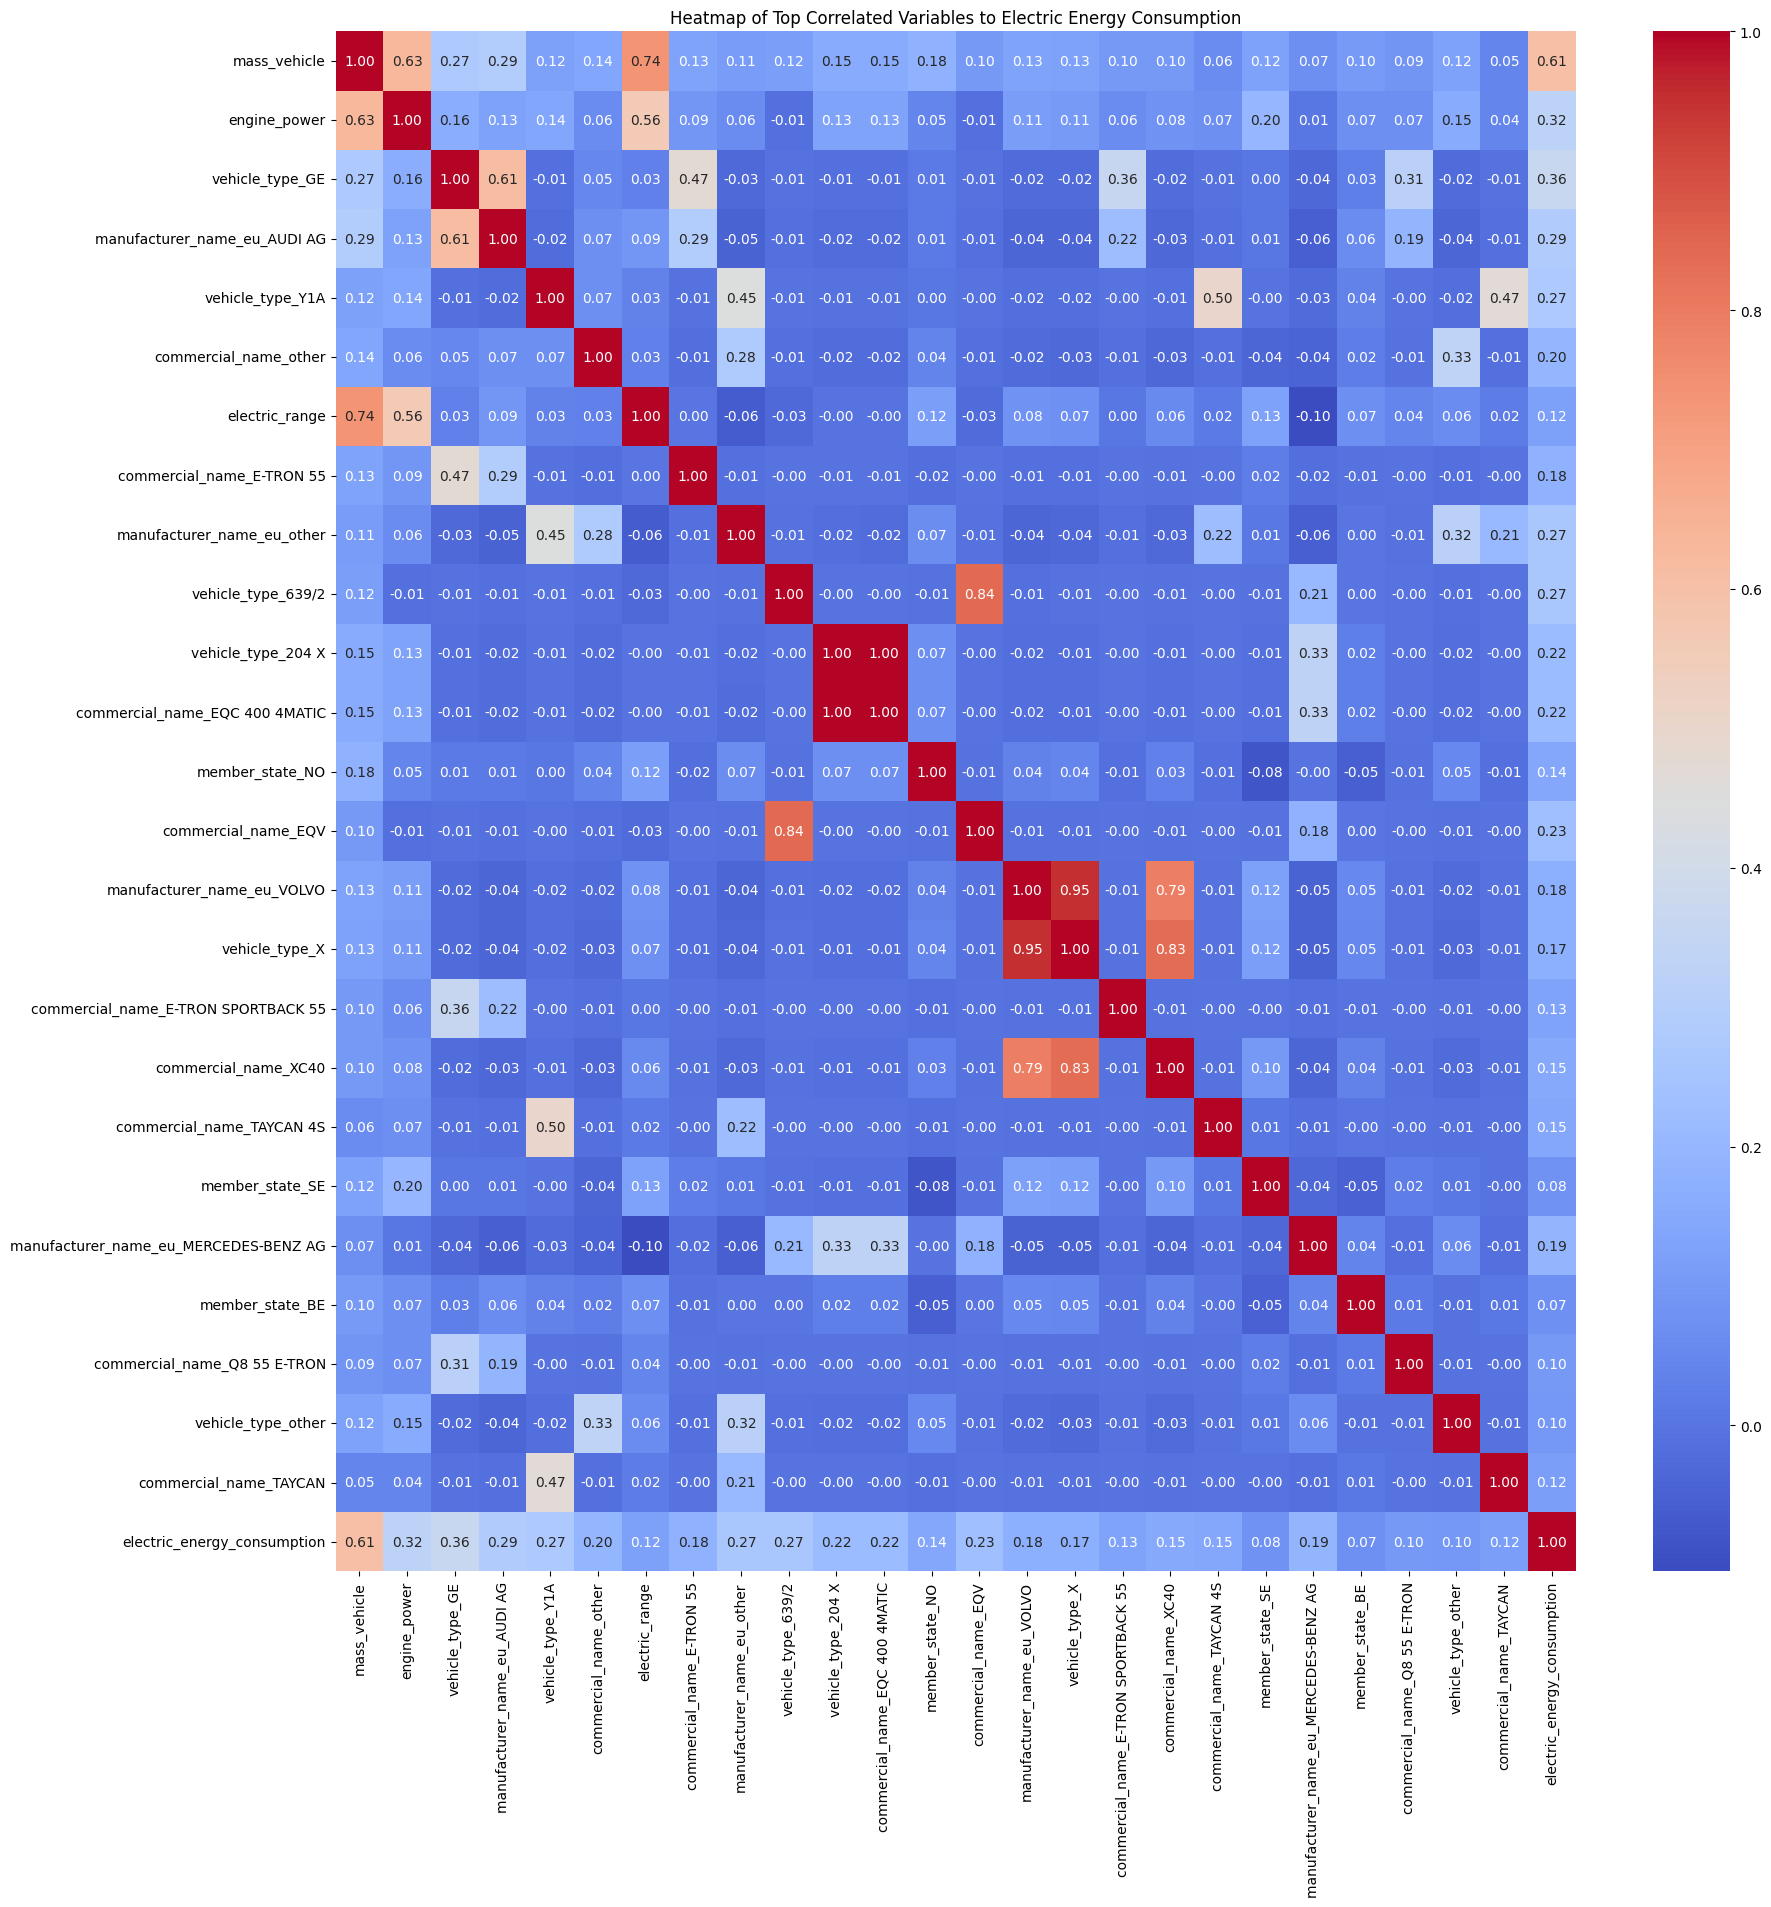

In [51]:
if DO_PREP_ANALYSIS:
    number_of_most_correlated_vars = 25
    # Select the top 10 most correlated variables to electric_energy_consumption
    top_corr_vars = corr_table.index[1:number_of_most_correlated_vars+1]  # Exclude the first one as it is the target itself

    # Add electric_energy_consumption to the top_corr_vars
    top_corr_vars_with_target = top_corr_vars.tolist() + ['electric_energy_consumption']

    # Create a subset of the correlation matrix with these variables
    # corr_matrix_subset = corr_matrix_electric.loc[top_corr_vars, top_corr_vars]
    corr_matrix_subset = corr_matrix_electric.loc[top_corr_vars_with_target, top_corr_vars_with_target]

    # Plot the heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix_subset, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title('Heatmap of Top Correlated Variables to Electric Energy Consumption')
    plt.show()

In [36]:
# check distribution of energy_consumption
df_enc["electric_energy_consumption"].describe()

count    3.801601e+06
mean     1.681083e+02
std      2.450656e+01
min      1.000000e+01
25%      1.550000e+02
50%      1.650000e+02
75%      1.770000e+02
max      5.830000e+02
Name: electric_energy_consumption, dtype: float64

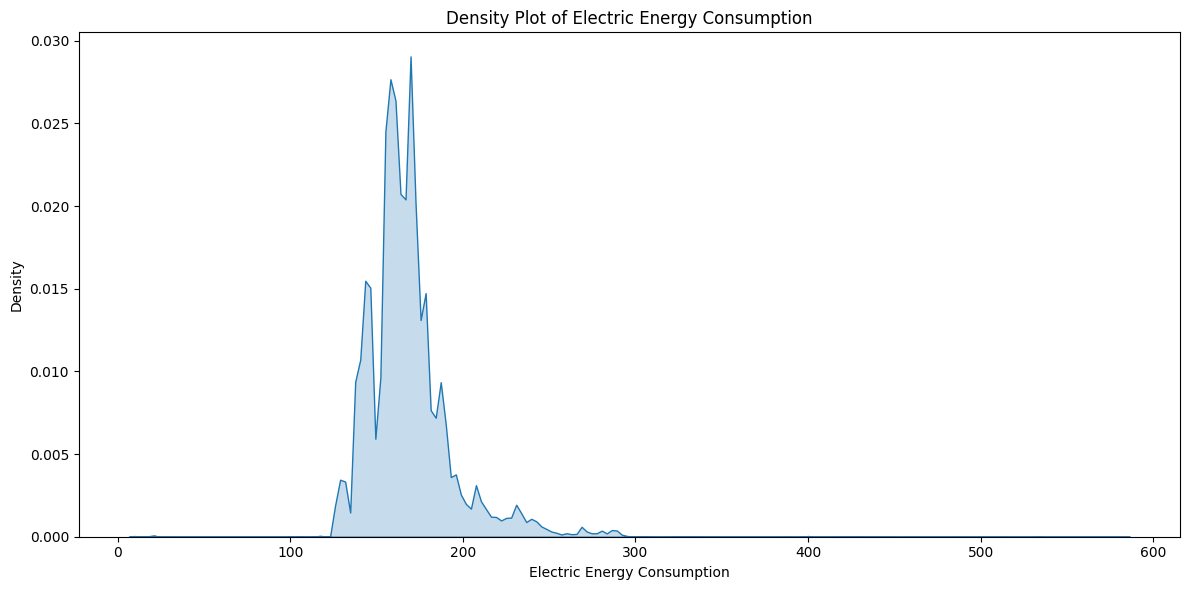

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Density Plot
sns.kdeplot(df_enc["electric_energy_consumption"], fill=True)
plt.title('Density Plot of Electric Energy Consumption')
plt.xlabel('Electric Energy Consumption')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [38]:
# from config import ENCODED_PREP_ELECTRIC_FILE
# df_enc.to_csv(ENCODED_PREP_ELECTRIC_FILE, index=False)

TODO consider feature selection

"""python

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=5)  # Keep top 5 features
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

reg.fit(X_train_reduced, X_test_reduced, y_train, y_test)

"""

## Split dataset
- features, target
- train, test

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X = df_enc.drop(columns = ELECTRIC_TARGET)
y = df_enc[ELECTRIC_TARGET]

In [41]:
# free up memory and delete unused variables
del df_enc

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# we're using higher test_size here to reduce time for compute due to X_train size
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

## Resample dataset (down) to save compute

* approach used as LazyPredict -> LazyRegressor for first model comparison kept getting stuck
* consider replacing with proper dimension reduction and encoding

In [43]:
# comment this if you want to execute against entire dataset

# sample down to 10% of X_train
n_samples = int(0.1 * len(X_train))

# KMeans to preserve structure
# from sklearn.cluster import KMeans

# # Cluster and select representative points
# # random state to allow reproducability
# kmeans = KMeans(n_clusters=n_samples, random_state=42)
# kmeans.fit(X_train)
# selected_indices = kmeans.labels_  # Cluster assignment
# X_train = X_train[selected_indices]
# y_train = y_train[selected_indices]


# Random Downsampling
from sklearn.utils import resample

X_train, y_train = resample(X_train, y_train, n_samples=n_samples, random_state=42)

## Feature Scaling

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
X_train.head()

,member_state_AT,member_state_BE,member_state_BG,member_state_CY,member_state_CZ,member_state_DE,member_state_DK,member_state_EE,member_state_ES,member_state_FI,...,commercial_name_iX3,commercial_name_other,category_of_vehicle_M1,category_of_vehicle_M1,category_of_vehicle_M1G,category_of_vehicle_N1,mass_vehicle,engine_power,year,electric_range
981250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2595.0,141.0,2022.0,387.0
3356637,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1936.0,150.0,2023.0,551.0
663025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2440.0,141.0,2021.0,401.0
963340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1919.0,158.0,2022.0,602.0
3490612,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1595.0,115.0,2023.0,395.0


In [46]:
# encode all variables that are scalable (will include encoded cat_cols)
cat_cols, quant_cols = categorize_categorical_quantitive_cols(X)

In [47]:
# free up memory and delete unused variables
del X, y

In [48]:
scaler = StandardScaler()
X_train[quant_cols] = scaler.fit_transform(X_train[quant_cols])
X_test[quant_cols] = scaler.fit_transform(X_test[quant_cols])

# we're also scaling encoded columns, consider only encoding quant_cols
# X_train.iloc[:, -5:]

In [49]:
# Save the datasets and scaler
joblib.dump((X_train, X_test, y_train, y_test), TRAIN_TEST_SPLIT_ELECTRIC_FILE)
joblib.dump(scaler, SCALER_ELECTRIC_FILE)

['files/electric-scaler.pk1']